In [ ]:
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

# Load your data
df = pd.read_csv('/kaggle/input/fake-reviews-data/fake reviews dataset.csv')
# Initialize the LabelEncoder
le = LabelEncoder()


# Split your data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text_'], df['label'], test_size=0.2, random_state=42)

# Initialize the tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# Tokenize the texts
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

# Fit the LabelEncoder and transform the labels
train_labels = le.fit_transform(train_labels)
test_labels = le.transform(test_labels)

# Now you can convert your labels to tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Create a PyTorch dataset
class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = FakeNewsDataset(train_encodings, train_labels)
test_dataset = FakeNewsDataset(test_encodings, test_labels)

# Initialize the model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='/kaggle/working/results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/kaggle/working/logs',
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Create the trainer and train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics, 
)

In [ ]:
trainer.train()
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import numpy as np
metrics = trainer.evaluate()

# Print the metrics
for key, value in metrics.items():
    print(f"{key}: {value}")

In [ ]:
predictions, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import roc_auc_score, confusion_matrix

# Compute AUC-ROC
auc = roc_auc_score(labels, predictions)

# Compute confusion matrix
cm = confusion_matrix(labels, predictions)

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, _ = roc_curve(labels, predictions)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
TOKENIZERS_PARALLELISM= False

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
# Load some text data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

import warnings

# Ignore user warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Load your data
df = pd.read_csv('/kaggle/input/fake-reviews-data/fake reviews dataset.csv')
# Initialize the LabelEncoder
le = LabelEncoder()


# Split your data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text_'], df['label'], test_size=0.2, random_state=42)

# Create a count vectorizer
vectorizer = CountVectorizer()

# Transform the training data to document-term matrix
X_train_counts = vectorizer.fit_transform(X_train)

# Train a MultinomialNB model
nb = MultinomialNB()
nb.fit(X_train_counts, y_train)

# Compute the log-count ratios
log_count_ratio = nb.feature_log_prob_[1] - nb.feature_log_prob_[0]

# Create new features for the SVM
X_train_features = X_train_counts.multiply(log_count_ratio)

# Train a LinearSVC model
svm = LinearSVC()
svm.fit(X_train_features, y_train)

# Transform the test data to document-term matrix
X_test_counts = vectorizer.transform(X_test)

# Create new features for the SVM
X_test_features = X_test_counts.multiply(log_count_ratio)

# Evaluate the model
print("Test Accuracy: ", svm.score(X_test_features, y_test))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Generate predictions
predictions = svm.predict(X_test_features)

# Compute accuracy
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: ', accuracy)

# Compute precision
precision = precision_score(y_test, predictions, average='weighted')
print('Precision: ', precision)

# Compute recall
recall = recall_score(y_test, predictions, average='weighted')
print('Recall: ', recall)

# Compute F1 score
f1 = f1_score(y_test, predictions, average='weighted')
print('F1 Score: ', f1)

In [ ]:
import numpy as np
print(np.unique(y_test))

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Binarize labels and predictions
labels = y_test
labels_bin = label_binarize(labels, classes=['CG', 'OR'])
predictions_bin = label_binarize(predictions, classes=['CG', 'OR'])

# Compute AUC-ROC
auc = roc_auc_score(labels_bin, predictions_bin, average='macro')

# Compute ROC curve for each class
fpr, tpr, _ = roc_curve(labels_bin.ravel(), predictions_bin.ravel())

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(labels, predictions)
# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from transformers import GPT2LMHeadModel
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')
# your data
df = pd.read_csv('/kaggle/input/fake-reviews-data/fake reviews dataset.csv')
# Initialize the LabelEncoder



# Split your data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text_'], df['label'], test_size=0.2, random_state=42)
le = LabelEncoder()

tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")

tokenizer.pad_token = tokenizer.eos_token

if not tokenizer.pad_token:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Fit and transform the labels
train_labels = le.fit_transform(train_labels)
test_labels = le.transform(test_labels)

# Now you can convert your labels to tensors
train_labels = torch.from_numpy(train_labels)
test_labels = torch.from_numpy(test_labels)

train_texts = train_texts.tolist()
test_texts = test_texts.tolist()

# Now you can tokenize your texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

class FakeReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).float()
        return item

    def __len__(self):
        return len(self.labels)


# Convert to Dataset
train_dataset = FakeReviewDataset(train_encodings, train_labels)
test_dataset = FakeReviewDataset(test_encodings, test_labels)


model = GPT2ForSequenceClassification.from_pretrained("distilgpt2")

# Define a padding token
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# Create the Trainer
training_args = TrainingArguments(
    output_dir='gptresults',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='gptlogs',
    gradient_accumulation_steps=2,
)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import numpy as np
metrics = trainer.evaluate()

# Print the metrics
for key, value in metrics.items():
    print(f"{key}: {value}")

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
# your data
df = pd.read_csv('/kaggle/input/fake-reviews-data/fake reviews dataset.csv')
# Initialize the LabelEncoder

class FakeReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx].unsqueeze(0)  # Add an extra dimension
        return item

    def __len__(self):
        return len(self.labels)

# Split your data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text_'], df['label'], test_size=0.2, random_state=42)
le = LabelEncoder()

# Fit and transform the labels
train_labels = le.fit_transform(train_labels)
test_labels = le.transform(test_labels)

# Now you can convert your labels to tensors
train_labels = torch.from_numpy(train_labels)
test_labels = torch.from_numpy(test_labels)

train_texts = train_texts.tolist()
test_texts = test_texts.tolist()

if not tokenizer.pad_token:
    tokenizer.pad_token = tokenizer.eos_token
# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Tokenize the data
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)


train_dataset = FakeReviewDataset(train_encodings, train_labels)
test_dataset = FakeReviewDataset(test_encodings, test_labels)


# Create the Trainer
training_args = TrainingArguments(
    output_dir='bertresults',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='bertlogs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,  # use the function defined in the previous step
)

# Train the model
trainer.train()

In [ ]:
import numpy as np
metrics = trainer.evaluate()

# Print the metrics
for key, value in metrics.items():
    print(f"{key}: {value}")

In [ ]:
predictions, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import roc_auc_score, confusion_matrix

# Compute AUC-ROC
auc = roc_auc_score(labels, predictions)

# Compute confusion matrix
cm = confusion_matrix(labels, predictions)

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, _ = roc_curve(labels, predictions)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Load your data
df = pd.read_csv('/kaggle/input/fake-reviews-data/fake reviews dataset.csv')

# List of categories
categories = df['category'].unique()

# Initialize a CountVectorizer
vectorizer = CountVectorizer()

# Loop over each category
for category in categories:
    # Filter data for the current category
    df_filtered = df[df['category'] == category]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df_filtered['text_'], df_filtered['label'], test_size=0.2, random_state=42)

    # Vectorize the reviews
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Train model
    model = LogisticRegression()
    model.fit(X_train_vec, y_train)

    # Make predictions
    predictions = model.predict(X_test_vec)

    # Compute accuracy
    accuracy = accuracy_score(y_test, predictions)
    print(f'Accuracy for {category}:', accuracy)
    
    
    # Compute AUC-ROC
    y_test_bin = label_binarize(y_test, classes=['CG', 'OR'])
    predictions_bin = label_binarize(predictions, classes=['CG', 'OR'])
    auc_score = roc_auc_score(y_test_bin, predictions_bin)
    print(f'AUC-ROC for {category}:', auc_score)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, predictions)
    print(f'Confusion matrix for {category}:\n', cm)

    # Plot confusion matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title(f'Confusion Matrix for {category}')
    plt.show()

    # Compute precision, recall, F1 score
    report = classification_report(y_test, predictions)
    print(f'Classification report for {category}:\n', report)

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    lb = LabelBinarizer()
    lb.fit(labels)
    labels = lb.transform(labels)
    preds = lb.transform(preds)


    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Compute the confusion matrix
    conf_mat = confusion_matrix(labels, preds)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=le.classes_)
    disp.plot()
    plt.show()
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }

# your data
df = pd.read_csv('/kaggle/input/fake-reviews-data/fake reviews dataset.csv')


# List of categories
categories = df['category'].unique()

# Initialize the LabelEncoder
le = LabelEncoder()

class FakeReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx].unsqueeze(0)  # Add an extra dimension
        return item

    def __len__(self):
        return len(self.labels)
    
# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

if not tokenizer.pad_token:
    tokenizer.pad_token = tokenizer.eos_token

# Create the Trainer
training_args = TrainingArguments(
    output_dir='bertresults',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='bertlogs',
)

# Loop over each category
for category in categories:
    # Filter data for the current category
    print("Category",category)
    df_filtered = df[df['category'] == category]

    # Split your data into training and test sets
    train_texts, test_texts, train_labels, test_labels = train_test_split(df_filtered['text_'], df_filtered['label'], test_size=0.2, random_state=42)

    # Fit and transform the labels
    train_labels = le.fit_transform(train_labels)
    test_labels = le.transform(test_labels)

    # Now you can convert your labels to tensors
    train_labels = torch.from_numpy(train_labels)
    test_labels = torch.from_numpy(test_labels)

    train_texts = train_texts.tolist()
    test_texts = test_texts.tolist()

    # Tokenize the data
    train_encodings = tokenizer(train_texts, truncation=True, padding=True)
    test_encodings = tokenizer(test_texts, truncation=True, padding=True)

    train_dataset = FakeReviewDataset(train_encodings, train_labels)
    test_dataset = FakeReviewDataset(test_encodings, test_labels)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,  # use the function defined in the previous step
    )

    # Train the model
    trainer.train()
    metrics = trainer.evaluate()
    # Print the metrics
    for key, value in metrics.items():
        print(f"{key}: {value}")

In [5]:
TOKENIZERS_PARALLELISM= False

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Category Home_and_Kitchen_5


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/tmp/ipykernel_34/438334483.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])  # Add an extra dimension
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


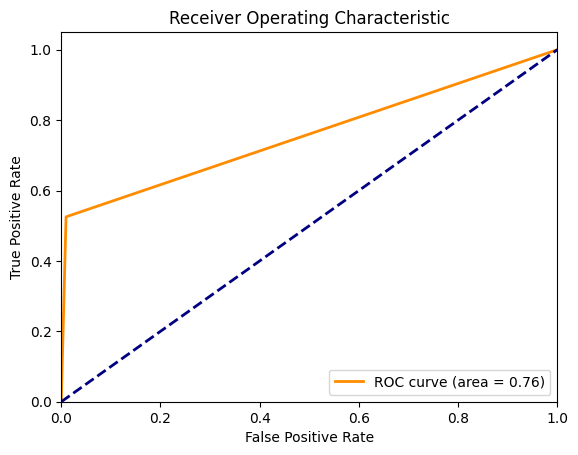

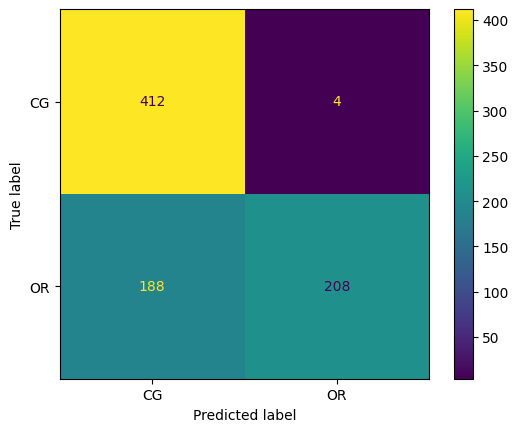

eval_loss: 0.7461777925491333
eval_accuracy: 0.7635467980295566
eval_f1: 0.6842105263157896
eval_precision: 0.9811320754716981
eval_recall: 0.5252525252525253
eval_runtime: 14.8341
eval_samples_per_second: 54.739
eval_steps_per_second: 0.472
epoch: 3.0
Category Sports_and_Outdoors_5


/tmp/ipykernel_34/438334483.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])  # Add an extra dimension
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


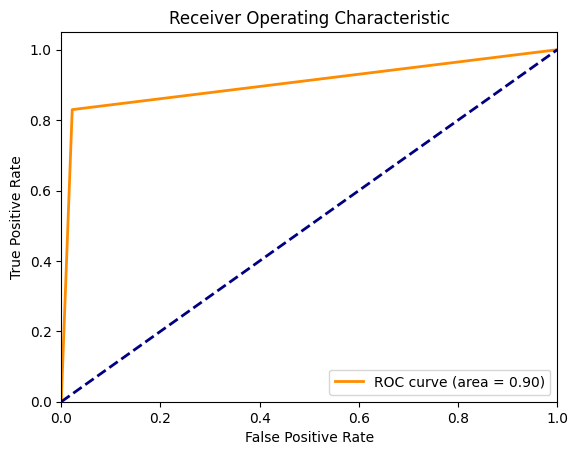

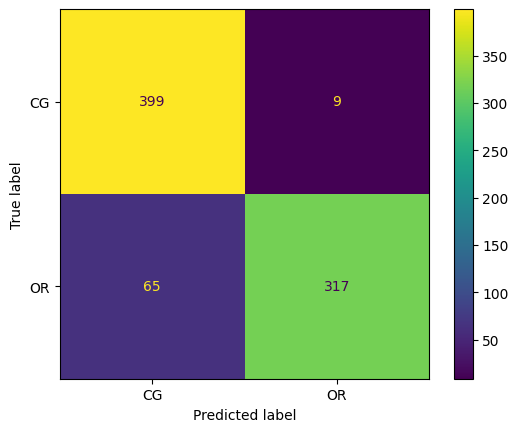

eval_loss: 0.2770828306674957
eval_accuracy: 0.9063291139240506
eval_f1: 0.8954802259887005
eval_precision: 0.9723926380368099
eval_recall: 0.8298429319371727
eval_runtime: 14.3788
eval_samples_per_second: 54.942
eval_steps_per_second: 0.487
epoch: 3.0
Category Electronics_5


/tmp/ipykernel_34/438334483.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])  # Add an extra dimension
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


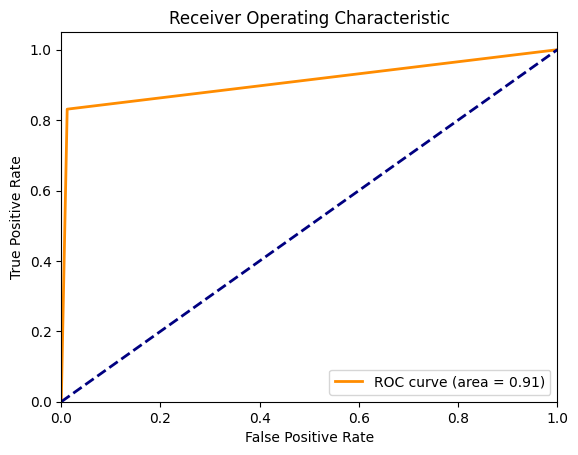

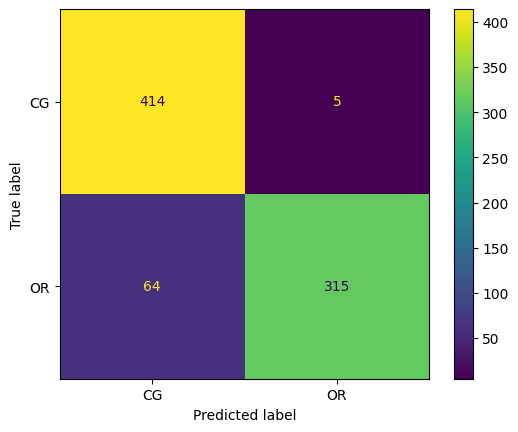

eval_loss: 0.3615263104438782
eval_accuracy: 0.9135338345864662
eval_f1: 0.9012875536480688
eval_precision: 0.984375
eval_recall: 0.8311345646437994
eval_runtime: 14.6903
eval_samples_per_second: 54.321
eval_steps_per_second: 0.477
epoch: 3.0
Category Movies_and_TV_5


/tmp/ipykernel_34/438334483.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])  # Add an extra dimension
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


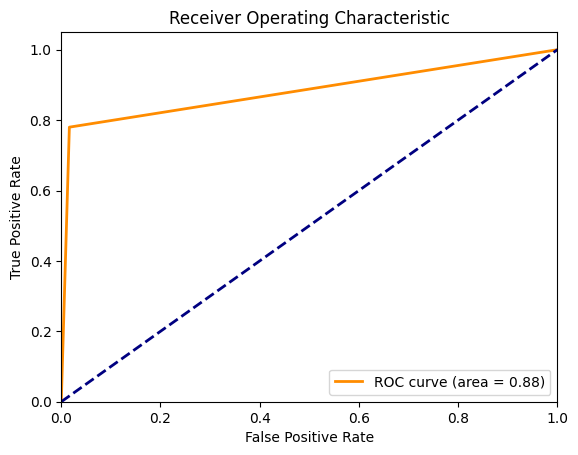

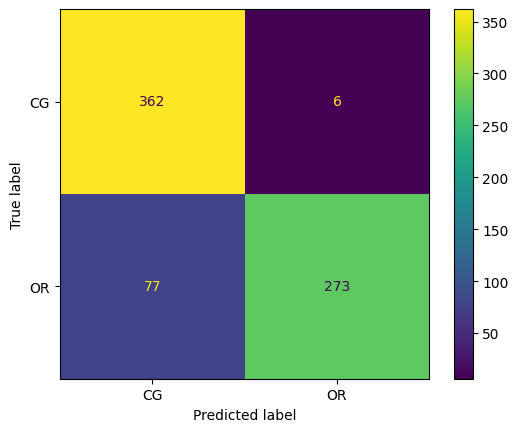

eval_loss: 0.5239453911781311
eval_accuracy: 0.8844011142061281
eval_f1: 0.8680445151033387
eval_precision: 0.978494623655914
eval_recall: 0.78
eval_runtime: 13.2389
eval_samples_per_second: 54.234
eval_steps_per_second: 0.453
epoch: 3.0
Category Tools_and_Home_Improvement_5


/tmp/ipykernel_34/438334483.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])  # Add an extra dimension
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


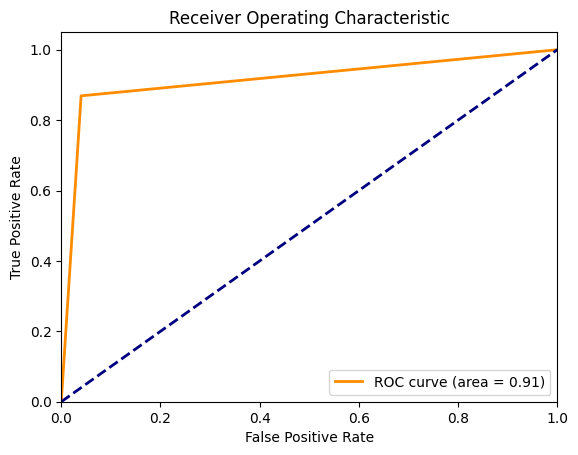

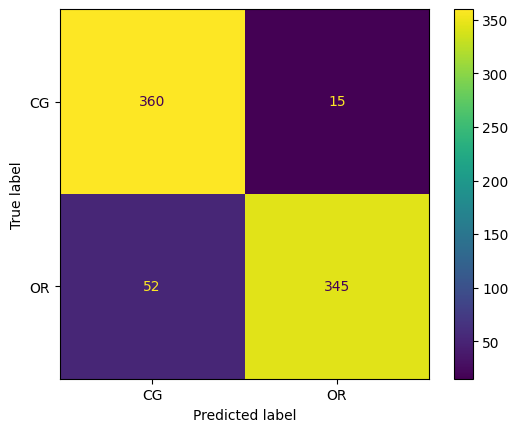

eval_loss: 0.39519402384757996
eval_accuracy: 0.9132124352331606
eval_f1: 0.9114927344782034
eval_precision: 0.9583333333333334
eval_recall: 0.8690176322418136
eval_runtime: 13.4592
eval_samples_per_second: 57.358
eval_steps_per_second: 0.52
epoch: 3.0
Category Pet_Supplies_5


/tmp/ipykernel_34/438334483.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])  # Add an extra dimension
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


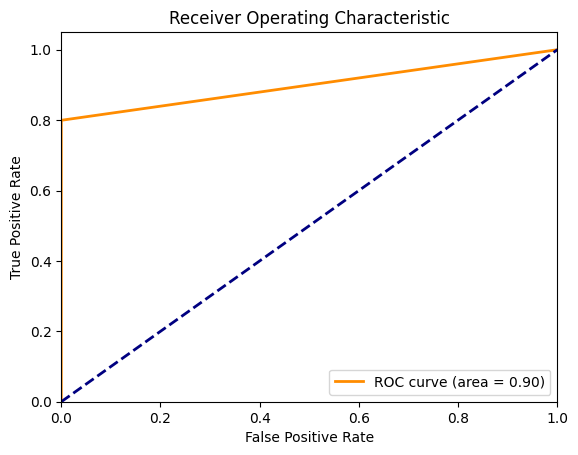

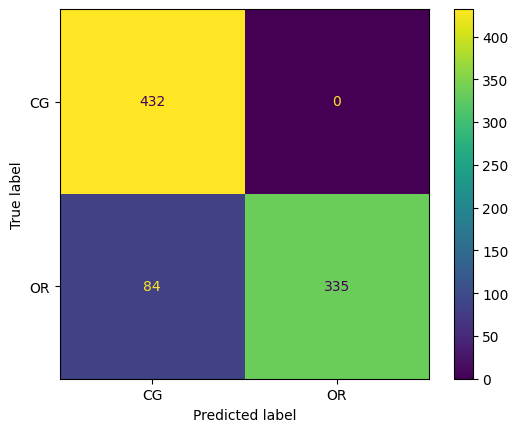

eval_loss: 0.42259451746940613
eval_accuracy: 0.9012925969447708
eval_f1: 0.8885941644562334
eval_precision: 1.0
eval_recall: 0.7995226730310262
eval_runtime: 12.7166
eval_samples_per_second: 66.92
eval_steps_per_second: 0.55
epoch: 3.0
Category Kindle_Store_5


/tmp/ipykernel_34/438334483.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])  # Add an extra dimension
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


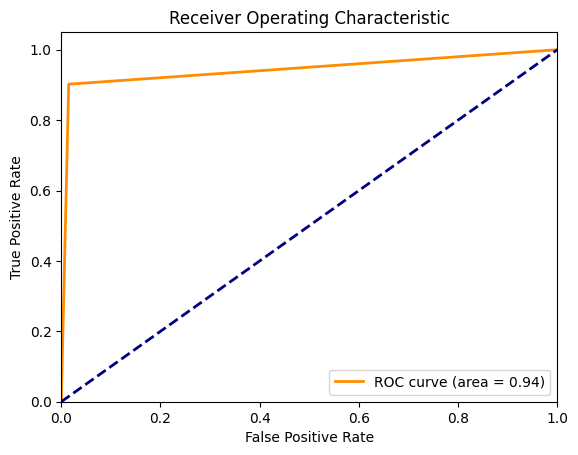

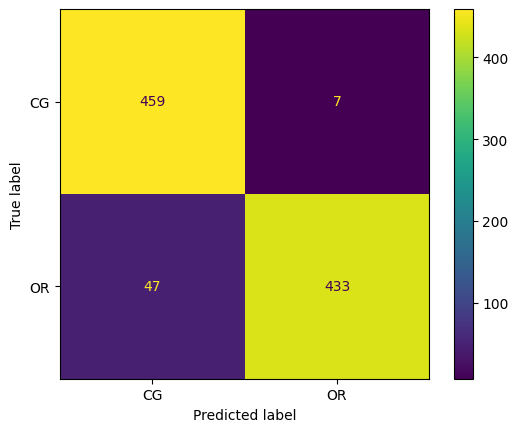

eval_loss: 0.3157121539115906
eval_accuracy: 0.9429175475687104
eval_f1: 0.941304347826087
eval_precision: 0.9840909090909091
eval_recall: 0.9020833333333333
eval_runtime: 14.8281
eval_samples_per_second: 63.798
eval_steps_per_second: 0.54
epoch: 3.0
Category Books_5


/tmp/ipykernel_34/438334483.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])  # Add an extra dimension
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


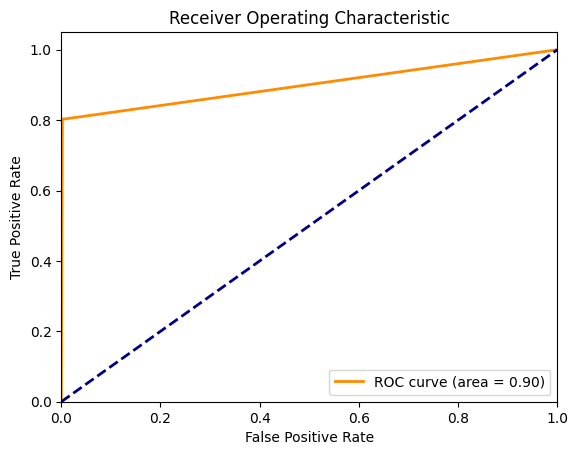

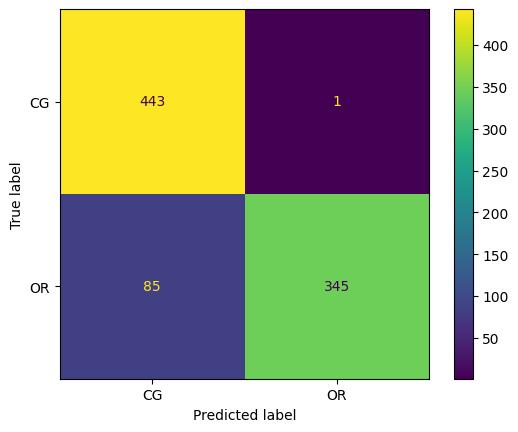

eval_loss: 0.5004860758781433
eval_accuracy: 0.9016018306636155
eval_f1: 0.8891752577319588
eval_precision: 0.9971098265895953
eval_recall: 0.8023255813953488
eval_runtime: 15.7113
eval_samples_per_second: 55.629
eval_steps_per_second: 0.446
epoch: 3.0
Category Toys_and_Games_5


/tmp/ipykernel_34/438334483.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])  # Add an extra dimension
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


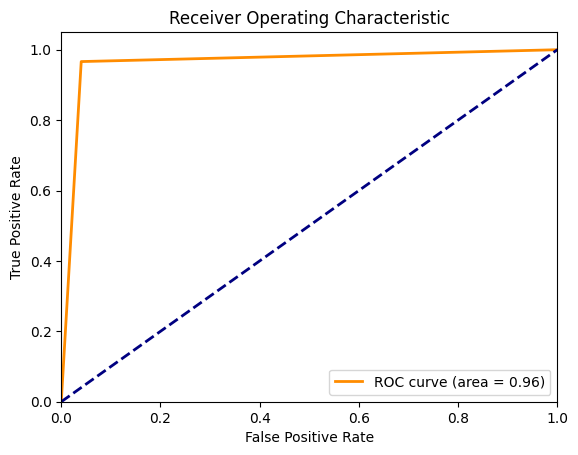

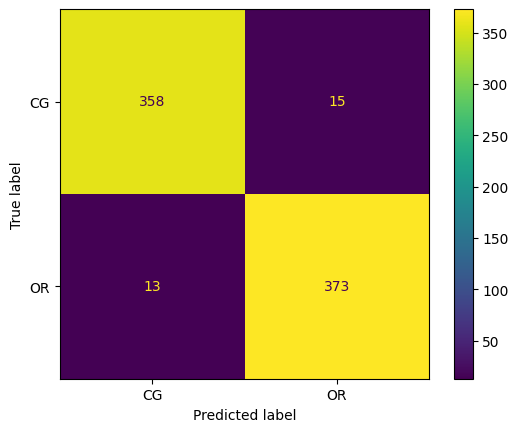

eval_loss: 0.14864259958267212
eval_accuracy: 0.9631093544137023
eval_f1: 0.9638242894056848
eval_precision: 0.961340206185567
eval_recall: 0.966321243523316
eval_runtime: 11.8173
eval_samples_per_second: 64.228
eval_steps_per_second: 0.508
epoch: 3.0
Category Clothing_Shoes_and_Jewelry_5


/tmp/ipykernel_34/438334483.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])  # Add an extra dimension
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


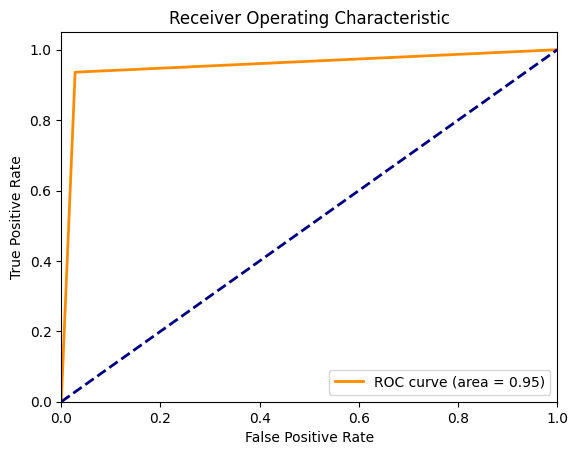

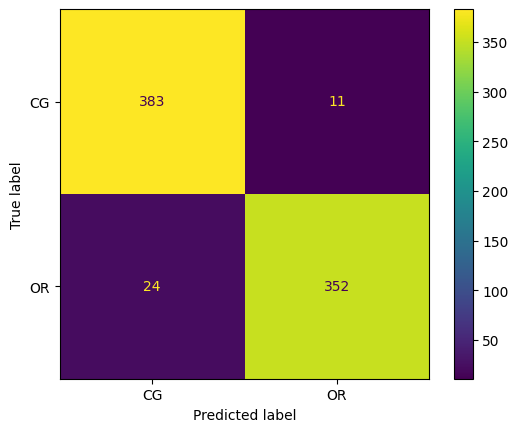

eval_loss: 0.20350408554077148
eval_accuracy: 0.9545454545454546
eval_f1: 0.952638700947226
eval_precision: 0.9696969696969697
eval_recall: 0.9361702127659575
eval_runtime: 13.4541
eval_samples_per_second: 57.232
eval_steps_per_second: 0.52
epoch: 3.0


In [6]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from imblearn.over_sampling import SMOTE
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
import numpy as np

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    lb = LabelBinarizer()
    lb.fit(labels)
    labels = lb.transform(labels)
    preds = lb.transform(preds)

    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Compute the confusion matrix
    conf_mat = confusion_matrix(labels, preds)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=le.classes_)
    disp.plot()
    plt.show()
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }

# your data
df = pd.read_csv('/kaggle/input/fake-reviews-data/fake reviews dataset.csv')

# List of categories
categories = df['category'].unique()

# Initialize the LabelEncoder
le = LabelEncoder()

class FakeReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])  # Add an extra dimension
        return item

    def __len__(self):
        return len(self.labels)

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

if not tokenizer.pad_token:
    tokenizer.pad_token = tokenizer.eos_token

# Create the Trainer
training_args = TrainingArguments(
    output_dir='bertresults',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='bertlogs',
)

# Loop over each category
for category in categories:
    # Filter data for the current category
    print("Category",category)
    df_filtered = df[df['category'] == category]

    # Split your data into training and test sets
    train_texts, test_texts, train_labels, test_labels = train_test_split(df_filtered['text_'], df_filtered['label'], test_size=0.2, random_state=42)

    # Fit and transform the labels
    train_labels = le.fit_transform(train_labels)
    test_labels = le.transform(test_labels)

    # Tokenize the data
    train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
    test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

    # Convert tokenized data to tensor
    train_encodings_tensors = torch.tensor([i for i in train_encodings['input_ids']])
    test_encodings_tensors = torch.tensor([i for i in test_encodings['input_ids']])

    # Apply SMOTE on the tokenized data
    oversample = SMOTE()
    train_encodings_res, train_labels_res = oversample.fit_resample(np.array(train_encodings_tensors), train_labels)

    # Convert resampled data back to list
    train_texts_res = [tokenizer.decode(i) for i in train_encodings_res]

    # Convert resampled labels back to tensor
    train_labels = torch.from_numpy(train_labels_res)

    # Tokenize the resampled data
    train_encodings_res = tokenizer(train_texts_res, truncation=True, padding=True)

    # Create the datasets
    train_dataset = FakeReviewDataset(train_encodings_res, train_labels)
    test_dataset = FakeReviewDataset(test_encodings, test_labels)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,  # use the function defined in the previous step
    )

    # Train the model
    trainer.train()
    metrics = trainer.evaluate()
    # Print the metrics
    for key, value in metrics.items():
        print(f"{key}: {value}")

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Vectorize the text data
vectorizer = TfidfVectorizer(ngram_range=(1, 2), binary=True)

# Create the models
models = [
    ('SVM', LinearSVC()),
    ('Logistic Regression', LogisticRegression(max_iter=10000))
]

# Split your data into training and test sets
le = LabelEncoder()
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text_'], df['label'], test_size=0.2, random_state=42)

# Fit and transform the labels
train_labels = le.fit_transform(train_labels)
test_labels = le.transform(test_labels)

# Define the metrics
scoring = {'accuracy': 'accuracy',
           'precision': make_scorer(precision_score, average='weighted'),
           'recall': make_scorer(recall_score, average='weighted'),
           'f1': make_scorer(f1_score, average='weighted')}

# Loop over each model
for name, model in models:
    # Create a pipeline
    clf = make_pipeline(vectorizer, model)

    # Train the model
    clf.fit(train_texts, train_labels)

    # Evaluate the model
    scores = cross_validate(clf, test_texts, test_labels, cv=5, scoring=scoring)
    print(f"{name} Accuracy: %0.2f (+/- %0.2f)" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2))
    print(f"{name} Precision: %0.2f (+/- %0.2f)" % (scores['test_precision'].mean(), scores['test_precision'].std() * 2))
    print(f"{name} Recall: %0.2f (+/- %0.2f)" % (scores['test_recall'].mean(), scores['test_recall'].std() * 2))
    print(f"{name} F1: %0.2f (+/- %0.2f)" % (scores['test_f1'].mean(), scores['test_f1'].std() * 2))

SVM Accuracy: 0.91 (+/- 0.01)
SVM Precision: 0.92 (+/- 0.01)
SVM Recall: 0.91 (+/- 0.01)
SVM F1: 0.91 (+/- 0.01)
Logistic Regression Accuracy: 0.90 (+/- 0.02)
Logistic Regression Precision: 0.90 (+/- 0.02)
Logistic Regression Recall: 0.90 (+/- 0.02)
Logistic Regression F1: 0.90 (+/- 0.02)


In [7]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from scipy import sparse

class NBSVM(BaseEstimator, ClassifierMixin):

    def __init__(self, alpha=1.0, C=1.0, max_iter=10000):
        self.alpha = alpha
        self.max_iter = max_iter
        self.C = C
        self.svm_ = LogisticRegression(C=self.C, max_iter=self.max_iter)

    def fit(self, X, y):
        X, y = check_X_y(X, y, 'csr')
        _, n_features = X.shape

        def pr(X, y_i, y):
            p = X[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(X,1,y) / pr(X,0,y)))
        X_nb = X.multiply(self._r)
        self.svm_.fit(X_nb, y)
        return self

    def predict(self, X):
        check_is_fitted(self)
        return self.svm_.predict(X.multiply(self._r))

    def predict_proba(self, X):
        check_is_fitted(self)
        return self.svm_.predict_proba(X.multiply(self._r))

# Vectorize the text data
vectorizer = TfidfVectorizer(ngram_range=(1, 2), binary=True)

# Create the models
model = NBSVM()

# Split your data into training and test sets
le = LabelEncoder()
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text_'], df['label'], test_size=0.2, random_state=42)

# Fit and transform the labels
train_labels = le.fit_transform(train_labels)
test_labels = le.transform(test_labels)

# Define the metrics
scoring = {'accuracy': 'accuracy',
           'precision': make_scorer(precision_score, average='weighted'),
           'recall': make_scorer(recall_score, average='weighted'),
           'f1': make_scorer(f1_score, average='weighted')}

# Create a pipeline
clf = make_pipeline(vectorizer, model)

# Train the model
clf.fit(train_texts, train_labels)

# Evaluate the model
scores = cross_validate(clf, test_texts, test_labels, cv=5, scoring=scoring)
print(f"NBSVM Accuracy: %0.2f (+/- %0.2f)" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2))
print(f"NBSVM Precision: %0.2f (+/- %0.2f)" % (scores['test_precision'].mean(), scores['test_precision'].std() * 2))
print(f"NBSVM Recall: %0.2f (+/- %0.2f)" % (scores['test_recall'].mean(), scores['test_recall'].std() * 2))
print(f"NBSVM F1: %0.2f (+/- %0.2f)" % (scores['test_f1'].mean(), scores['test_f1'].std() * 2))

NBSVM Accuracy: 0.88 (+/- 0.02)
NBSVM Precision: 0.89 (+/- 0.02)
NBSVM Recall: 0.88 (+/- 0.02)
NBSVM F1: 0.88 (+/- 0.02)


In [8]:
from sklearn.tree import DecisionTreeClassifier

# Vectorize the text data
vectorizer = TfidfVectorizer(ngram_range=(1, 2), binary=True)

# Create the models
model = DecisionTreeClassifier()

# Split your data into training and test sets
le = LabelEncoder()
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text_'], df['label'], test_size=0.2, random_state=42)

# Fit and transform the labels
train_labels = le.fit_transform(train_labels)
test_labels = le.transform(test_labels)

# Define the metrics
scoring = {'accuracy': 'accuracy',
           'precision': make_scorer(precision_score, average='weighted'),
           'recall': make_scorer(recall_score, average='weighted'),
           'f1': make_scorer(f1_score, average='weighted')}

# Create a pipeline
clf = make_pipeline(vectorizer, model)

# Train the model
clf.fit(train_texts, train_labels)

# Evaluate the model
scores = cross_validate(clf, test_texts, test_labels, cv=5, scoring=scoring)
print(f"DecisionTree Accuracy: %0.2f (+/- %0.2f)" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2))
print(f"DecisionTree Precision: %0.2f (+/- %0.2f)" % (scores['test_precision'].mean(), scores['test_precision'].std() * 2))
print(f"DecisionTree Recall: %0.2f (+/- %0.2f)" % (scores['test_recall'].mean(), scores['test_recall'].std() * 2))
print(f"DecisionTree F1: %0.2f (+/- %0.2f)" % (scores['test_f1'].mean(), scores['test_f1'].std() * 2))

DecisionTree Accuracy: 0.70 (+/- 0.03)
DecisionTree Precision: 0.71 (+/- 0.03)
DecisionTree Recall: 0.70 (+/- 0.03)
DecisionTree F1: 0.70 (+/- 0.03)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Category Home_and_Kitchen_5
SMOTE-generated examples for category 'Home_and_Kitchen_5':
[CLS] rugged and easy to mount. this bottle opener will get you into a crisp brew that much quicker. it will also save you a trip to the dentist for chipped teeth after trying to impress the ladies. i mounted mine to a wooden cooler i made and it hasn't disappointed yet!                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
/n
[CLS] disappointed on how thin sheets are. the quality is just not good. nice, sturdy, and functional.                                                                                  

/tmp/ipykernel_34/3103116982.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])  # Add an extra dimension
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


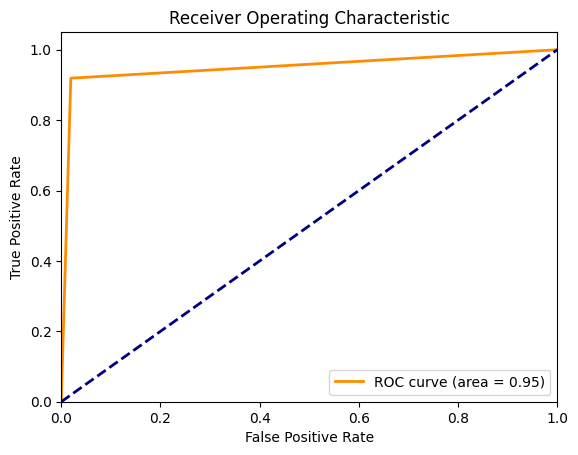

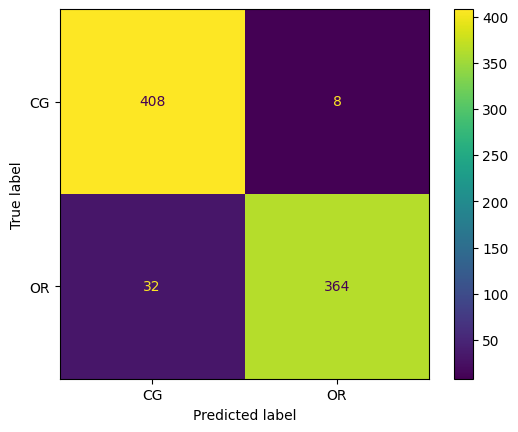

eval_loss: 0.13877379894256592
eval_accuracy: 0.9507389162561576
eval_f1: 0.9479166666666667
eval_precision: 0.978494623655914
eval_recall: 0.9191919191919192
eval_runtime: 14.9932
eval_samples_per_second: 54.158
eval_steps_per_second: 0.467
epoch: 3.0
Category Sports_and_Outdoors_5
SMOTE-generated examples for category 'Sports_and_Outdoors_5':
[CLS] it's soft comfortable holds revolvers and handguns well. the fit is nice and snug. the grip is so adjustable                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
/n
[CLS] i didn't know what to expect. the quality is 

/tmp/ipykernel_34/3103116982.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])  # Add an extra dimension
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


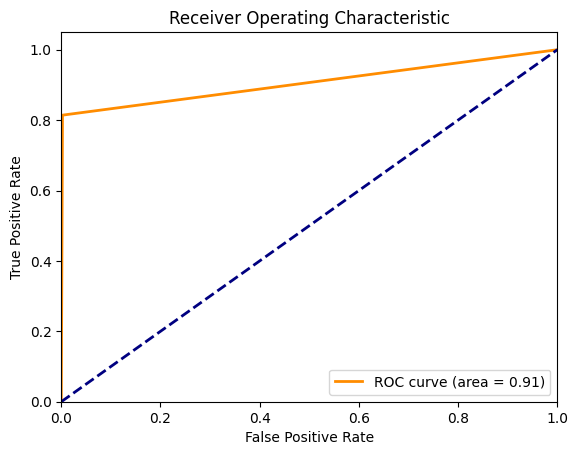

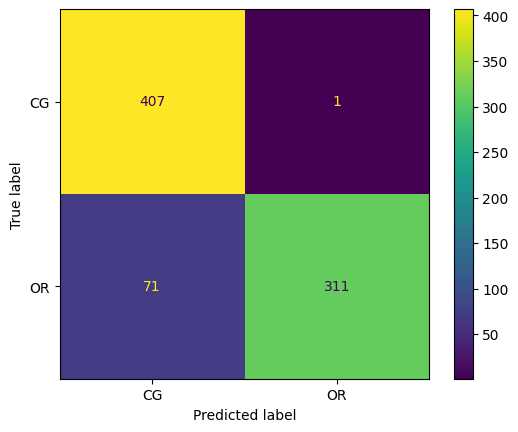

eval_loss: 0.4250105321407318
eval_accuracy: 0.9088607594936708
eval_f1: 0.8962536023054755
eval_precision: 0.9967948717948718
eval_recall: 0.8141361256544503
eval_runtime: 14.5262
eval_samples_per_second: 54.384
eval_steps_per_second: 0.482
epoch: 3.0
Category Electronics_5
SMOTE-generated examples for category 'Electronics_5':
[CLS] this strap worked just fine while i was on a river ride in costa rica. it also strapped right onto the helmet i used for the zip - line course. it allowed me to get some great footage of my friends while on vacation. highly recommend.                                                                                                                                                                                                                                                                                                                                                                                                                                             

/tmp/ipykernel_34/3103116982.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])  # Add an extra dimension
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


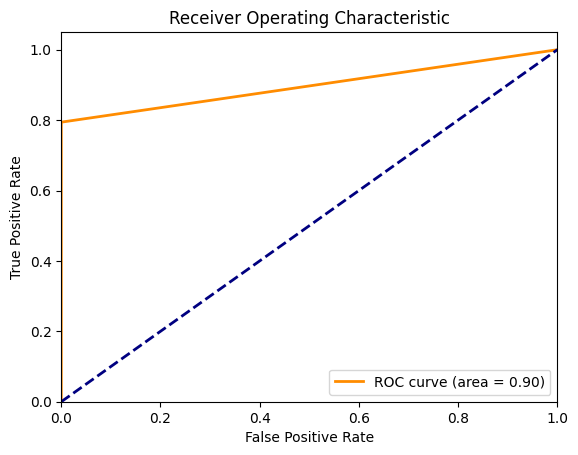

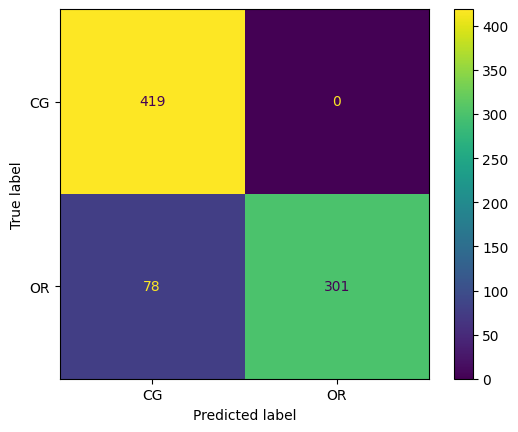

eval_loss: 0.4944733679294586
eval_accuracy: 0.9022556390977443
eval_f1: 0.8852941176470588
eval_precision: 1.0
eval_recall: 0.7941952506596306
eval_runtime: 14.6795
eval_samples_per_second: 54.361
eval_steps_per_second: 0.477
epoch: 3.0
Category Movies_and_TV_5
SMOTE-generated examples for category 'Movies_and_TV_5':
[CLS] i heard mixed reviews on this movie, and i decided to see it for myself. i am a big fan of the movie, and i am sure you will too. this movie is a great movie, and i am sure you will too. i recommend it to everyone. i recommend it to anyone who is a fan of the movie, or just wants to watch it for the first time. i can't say enough good things about this movie, so if you want to see it for yourself, you have to buy it. if you are a fan of the movie, and you like the movie, you have to buy it. it is a fun movie, and if you like the movie, you can watch it for yourself. i recommend it to everyone. you can also watch it for the first time. you can also watch it for the f

/tmp/ipykernel_34/3103116982.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])  # Add an extra dimension
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


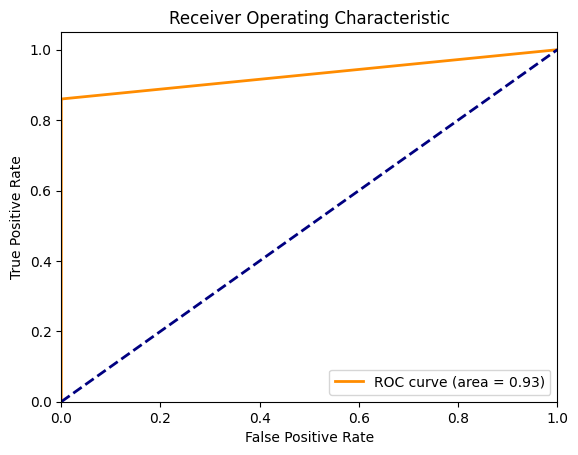

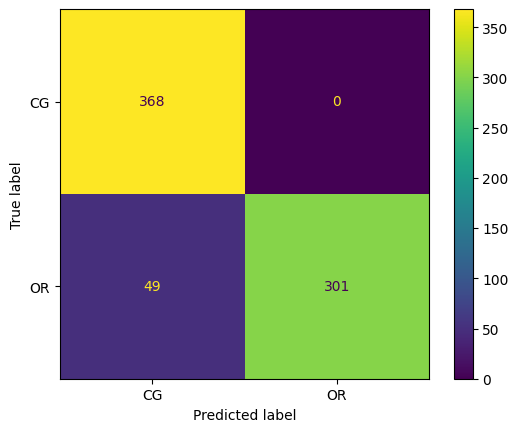

eval_loss: 0.33361488580703735
eval_accuracy: 0.9317548746518106
eval_f1: 0.924731182795699
eval_precision: 1.0
eval_recall: 0.86
eval_runtime: 13.2625
eval_samples_per_second: 54.138
eval_steps_per_second: 0.452
epoch: 3.0
Category Tools_and_Home_Improvement_5
SMOTE-generated examples for category 'Tools_and_Home_Improvement_5':
[CLS] the light didn't work. we have the wide - angle flashlight in our garage, and the one we bought from the local hardware store, but they're the only ones in town. we bought the bulb in the hopes of using it for a few years, but it was too dim. then we found this bulb and it worked perfectly. so now we have the light in our home. this bulb is a nice light for the price. it's very bright, and it                                                                                                                                                                                                                                                                           

/tmp/ipykernel_34/3103116982.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])  # Add an extra dimension
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


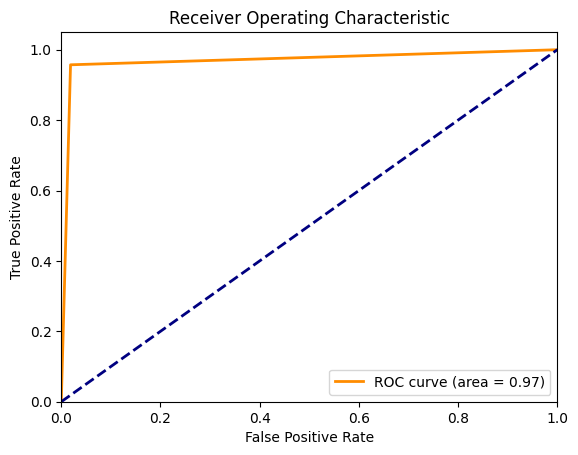

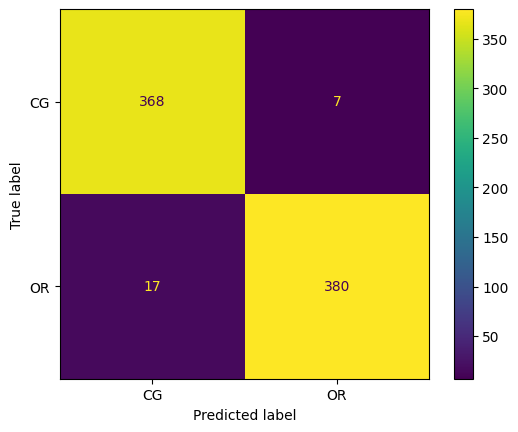

eval_loss: 0.14554241299629211
eval_accuracy: 0.9689119170984456
eval_f1: 0.9693877551020408
eval_precision: 0.9819121447028424
eval_recall: 0.9571788413098237
eval_runtime: 13.6712
eval_samples_per_second: 56.469
eval_steps_per_second: 0.512
epoch: 3.0
Category Pet_Supplies_5
SMOTE-generated examples for category 'Pet_Supplies_5':
[CLS] my 10 year old beagle ( cattle dog ) is a very aggressive chewer. he has chewed through every toy in the house before and then chewed through the entire toy again.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
/n
[CLS] this is the 

/tmp/ipykernel_34/3103116982.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])  # Add an extra dimension
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


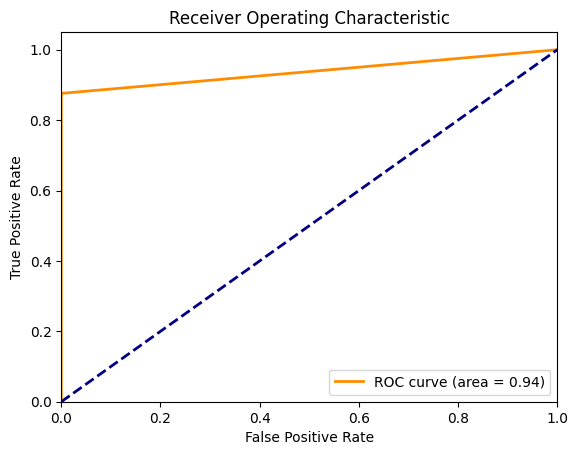

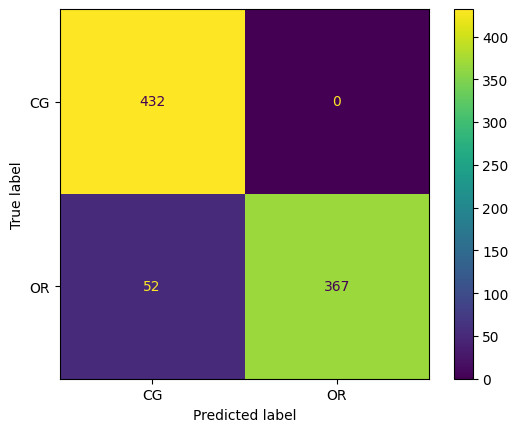

eval_loss: 0.3143077492713928
eval_accuracy: 0.9388954171562868
eval_f1: 0.9338422391857506
eval_precision: 1.0
eval_recall: 0.8758949880668258
eval_runtime: 12.9038
eval_samples_per_second: 65.949
eval_steps_per_second: 0.542
epoch: 3.0
Category Kindle_Store_5
SMOTE-generated examples for category 'Kindle_Store_5':
[CLS] gutted!!! i really don't know how else to describe how i feel right now. you have done it again megan, and i am so anxiously waiting for the 5th installment to filthy. bravo i say, bravo                                                                                                                                                                                                                                                                                                                                                                                                                                            
/n
[CLS] a friend of mine let me borrow the book and i was de

/tmp/ipykernel_34/3103116982.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])  # Add an extra dimension
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


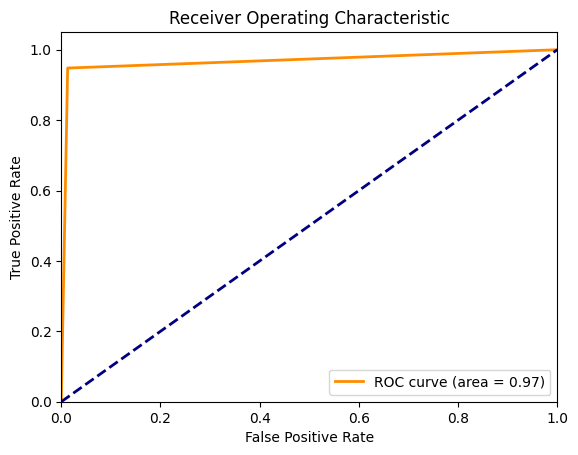

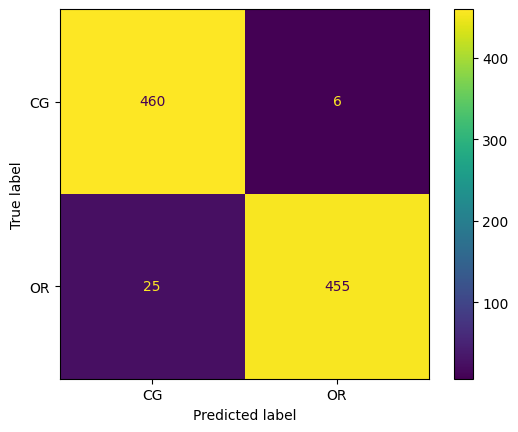

eval_loss: 0.16274282336235046
eval_accuracy: 0.96723044397463
eval_f1: 0.9670563230605738
eval_precision: 0.9869848156182213
eval_recall: 0.9479166666666666
eval_runtime: 15.0447
eval_samples_per_second: 62.879
eval_steps_per_second: 0.532
epoch: 3.0
Category Books_5
SMOTE-generated examples for category 'Books_5':
[CLS] started reading as an e - book and decided that i wanted the paper copies to read over and over.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
/n
[CLS] this is a good book. held my interest throughout. this is irving's first legal t

/tmp/ipykernel_34/3103116982.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])  # Add an extra dimension
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


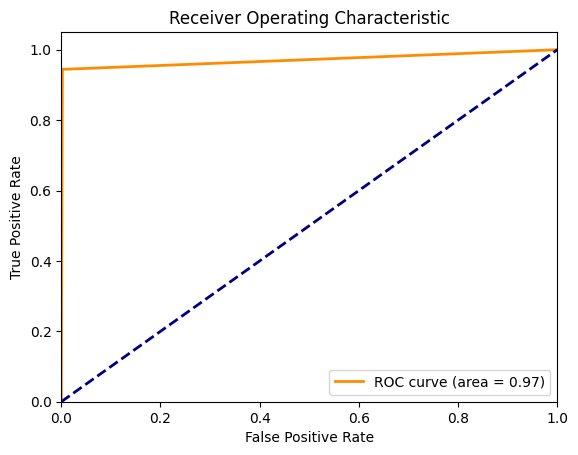

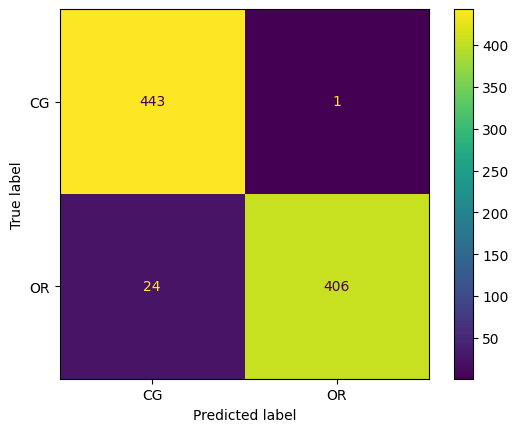

eval_loss: 0.1366497427225113
eval_accuracy: 0.971395881006865
eval_f1: 0.9701314217443251
eval_precision: 0.9975429975429976
eval_recall: 0.9441860465116279
eval_runtime: 15.9356
eval_samples_per_second: 54.846
eval_steps_per_second: 0.439
epoch: 3.0
Category Toys_and_Games_5
SMOTE-generated examples for category 'Toys_and_Games_5':
[CLS] update 1 / 10 / 2016 : despite the poor quality of these items and the doubled price, i decided to buy some more with plans to reinforce the hilt from the inside to withstand normal play. the sabres have changed! the buttons now have different and less desirable functionality. there is one switch that has an on / off position. when in the off position, the other button does nothing. with the on / off switch on, the other switch toggles between on and off - pretty useless! the saber cycles through the colors and the sounds ( which are, at least, still star wars sound effects ), so that you can no longer select which color blade you want. what self - r

/tmp/ipykernel_34/3103116982.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])  # Add an extra dimension
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


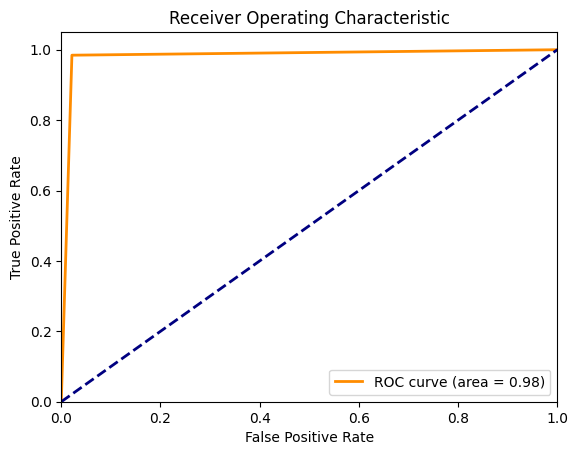

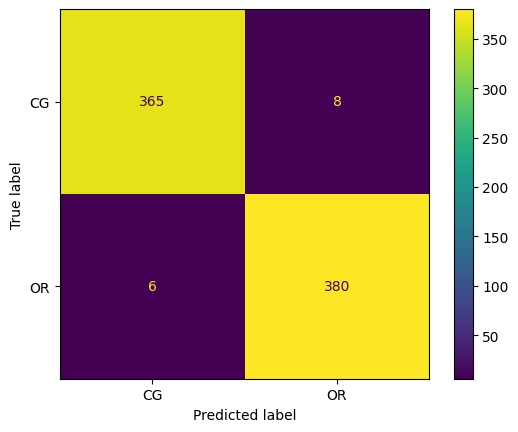

eval_loss: 0.06731971353292465
eval_accuracy: 0.9815546772068511
eval_f1: 0.9819121447028423
eval_precision: 0.979381443298969
eval_recall: 0.9844559585492227
eval_runtime: 11.9861
eval_samples_per_second: 63.323
eval_steps_per_second: 0.501
epoch: 3.0
Category Clothing_Shoes_and_Jewelry_5
SMOTE-generated examples for category 'Clothing_Shoes_and_Jewelry_5':
[CLS] as always, i love these sandals! bought my 5th or 6th pair over the last 5 - 6 years! wouldn't go with anything else!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
/n
[CLS] i bought one of these in 

/tmp/ipykernel_34/3103116982.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])  # Add an extra dimension
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


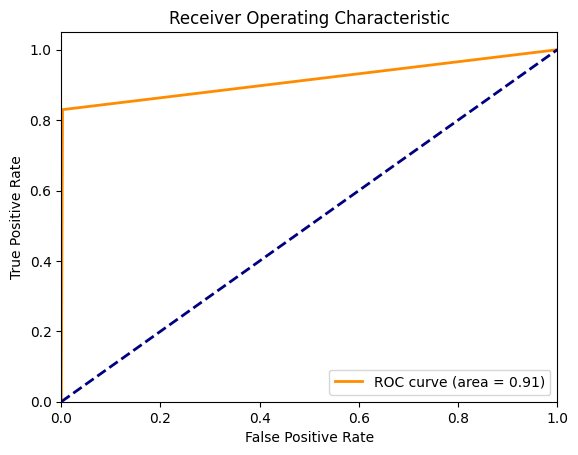

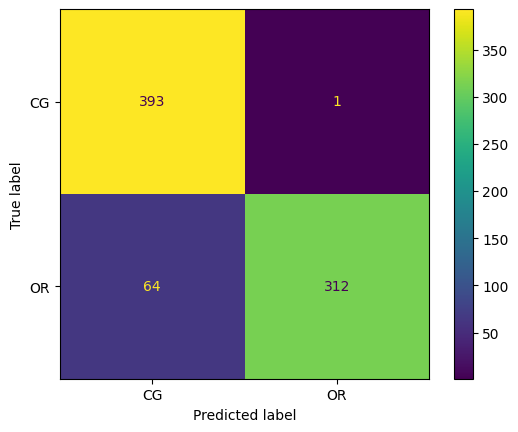

eval_loss: 0.36113038659095764
eval_accuracy: 0.9155844155844156
eval_f1: 0.9056603773584906
eval_precision: 0.9968051118210862
eval_recall: 0.8297872340425532
eval_runtime: 13.6425
eval_samples_per_second: 56.441
eval_steps_per_second: 0.513
epoch: 3.0


In [3]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from imblearn.over_sampling import SMOTE
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import random

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    lb = LabelBinarizer()
    lb.fit(labels)
    labels = lb.transform(labels)
    preds = lb.transform(preds)

    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Compute the confusion matrix
    conf_mat = confusion_matrix(labels, preds)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=le.classes_)
    disp.plot()
    plt.show()
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }

# your data
df = pd.read_csv('/kaggle/input/fake-reviews-data/fake reviews dataset.csv')

# List of categories
categories = df['category'].unique()

# Initialize the LabelEncoder
le = LabelEncoder()

class FakeReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])  # Add an extra dimension
        return item

    def __len__(self):
        return len(self.labels)

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

if not tokenizer.pad_token:
    tokenizer.pad_token = tokenizer.eos_token

# Create the Trainer
training_args = TrainingArguments(
    output_dir='bertresults',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='bertlogs',
)

# Loop over each category
for category in categories:
    # Filter data for the current category
    print("Category", category)
    df_filtered = df[df['category'] == category]

    # Split your data into training and test sets
    train_texts, test_texts, train_labels, test_labels = train_test_split(df_filtered['text_'], df_filtered['label'], test_size=0.2, random_state=42)

    # Fit and transform the labels
    train_labels = le.fit_transform(train_labels)
    test_labels = le.transform(test_labels)

    # Tokenize the data
    train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
    test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

    # Convert tokenized data to tensor
    train_encodings_tensors = torch.tensor([i for i in train_encodings['input_ids']])
    test_encodings_tensors = torch.tensor([i for i in test_encodings['input_ids']])

    # Apply SMOTE on the tokenized data
    oversample = SMOTE()
    train_encodings_res, train_labels_res = oversample.fit_resample(np.array(train_encodings_tensors), train_labels)

    # Convert resampled data back to list of strings
    train_texts_res = [tokenizer.decode(i) for i in train_encodings_res]
    
    train_texts_res = [text.replace('[PAD]', '').replace('[SEP]', '') for text in train_texts_res]
    num_examples = 5
    selected_examples = random.sample(train_texts_res, num_examples)
    # Print SMOTE-generated data
    print(f"SMOTE-generated examples for category '{category}':")
    for example in selected_examples:
        print(example)
        print('/n')

    # Convert resampled labels back to tensor
    train_labels = torch.from_numpy(train_labels_res)

    # Tokenize the resampled data
    train_encodings_res = tokenizer(train_texts_res, truncation=True, padding=True)

    # Create the datasets
    train_dataset = FakeReviewDataset(train_encodings_res, train_labels)
    test_dataset = FakeReviewDataset(test_encodings, test_labels)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,  # use the function defined in the previous step
    )

    # Train the model
    trainer.train()
    metrics = trainer.evaluate()
    # Print the metrics
    for key, value in metrics.items():
        print(f"{key}: {value}")

In [7]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

def evaluate_text(text):
    # Load the BERT tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)

    # Make the prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    # Map the predicted class to the label
    labels = ['OR', 'CG']
    predicted_label = labels[predicted_class]

    return predicted_label

# Example usage
text1 = "as always, i love these sandals! bought my 5th or 6th pair over the last 5 - 6 years! wouldn't go with anything else!"
text2 = "I was disappointed with this product. It didn't meet my needs and felt cheaply made. I wouldn't recommend it to others. The customer service was also unresponsive when I tried to reach out for assistance."

print("Text 1 is:", evaluate_text(text1))
print("Text 2 is:", evaluate_text(text2))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Text 1 is: CG


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Text 2 is: CG
